# Criando pequenos inputs

In [ ]:
import pandas as pd

df = pd.read_csv("scraper/input/hotels_24_merged.csv")

In [ ]:
df2 = pd.read_csv("scraper/input/hotels_2024.csv")
df2.shape

In [ ]:
df2[~df2.google_id.isin(df.google_id)].shape

In [ ]:
df[~df.google_id.isin(df2.google_id)]

In [ ]:
df2.iloc[0]

In [ ]:
df.shape

In [ ]:
df["sort_by"] = "newest"

In [ ]:
df[df.n_reviews_max.cumsum() < 10_000].shape

In [ ]:
cumsum = df.n_reviews_max.cumsum()
cumsum

In [ ]:
df["batch"] = -1

In [ ]:
dfs = []
step = 20_000
path = "./scraper/input/2025/"
for i in range(40):
    f = (cumsum > step*i) & (cumsum <= step*(i+1))
    df.loc[f, "batch"] = i
    dfi = df.loc[f]
    print(i, dfi.shape)
    dfs.append(dfi)
    dfi.to_csv(path+"hotels_batch_"+str(i).rjust(2,"0")+".csv", index=False)

In [ ]:
df.to_csv("./scraper/input/hotels_2025.csv", index=False)

# Normalizando e transformando índices

In [1]:
from uuid import uuid4
import faiss
import pandas as pd
import numpy as np
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.globals import set_debug
import asyncio
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline
import logging
from datetime import datetime
import time
import json
from tqdm import tqdm
import os
import re

from llms.utils import timeit
from llms.models import load_model, load_embedding, query_model, query_model_async

# logging.basicConfig(level=logging.DEBUG)
# set_debug(True)

QUERY_PREFIX_E5_INSTRUCT = "Instruct: Given a Portuguese question, retrieve relevant hotel reviews that best answer the question. \nQuery: "
DOC_PREFIX = ""
QUERY_PREFIX = ""

CREATE_INDEX = True
PATH_INDEX = "data/faiss_index_gte_v5"
INDEX_BATCH_SIZE = 10_000
N_SAMPLES = None
N_RESPONSES = 5
FETCH_K = 1000
MAX_VECTOR_STORES = 1000
# PATH_DATA = "data/df_prep_2024-12-09_08-23-45_627733.pq"
PATH_DATA = "data/df_index_2025_v1.pq"
EMBEDDING_MODEL = "gte"

In [2]:
folders = os.listdir(PATH_INDEX)
f = folders[0]

In [ ]:
embeddings, _ = load_embedding("gte", task_type="retrieval_document")

In [ ]:
embeddings.embed_query("textoooooo bem quadrado bem normalizado").__len__()

In [30]:
vector_store_l2 = FAISS.load_local(
    f"{PATH_INDEX}/{f}",
    embeddings,
    allow_dangerous_deserialization=True,
)

index: faiss.Index = vector_store_l2.index
vectors = index.reconstruct_n(0, index.ntotal)

In [40]:
index_ip = faiss.IndexFlatIP(index.d)
index_ip.add(vectors)

In [41]:
vector_store_ip = FAISS(
    embedding_function=embeddings,
    index=index_ip,
    docstore=InMemoryDocstore(vector_store_l2.docstore._dict),
    index_to_docstore_id=vector_store_l2.index_to_docstore_id,
)

In [ ]:
(vector_store_ip.index.reconstruct_n(0, 1)[0] == vector_store_l2.index.reconstruct_n(0, 1)[0]).all()

In [50]:
assert vector_store_ip.index.d == vector_store_l2.index.d
assert vector_store_ip.index.ntotal == vector_store_l2.index.ntotal
assert vector_store_ip.docstore._dict == vector_store_l2.docstore._dict
assert vector_store_ip.index_to_docstore_id == vector_store_l2.index_to_docstore_id
assert (vector_store_ip.index.reconstruct_n(0, 1)[0] == vector_store_l2.index.reconstruct_n(0, 1)[0]).all()

In [ ]:
np.linalg.norm(vector_store_ip.index.reconstruct_n(0, 1)[0]) == 1

In [24]:
# get all indexes of index
vectors = index.reconstruct_n(0, index.ntotal)

In [ ]:
index_to_docstore_id = vector_store_l2.index_to_docstore_id

In [19]:
from langchain_community.vectorstores import InMemoryVectorStore
metadata = vector_store_l2.docstore._dict

In [ ]:
metadata['3b253b8c-9ecb-4a47-a29b-597057358e77'].page_content

In [ ]:
vector_store_l2.add_embeddings(vectors, )

In [ ]:
pd.Series(vectors[0]).describe()


In [ ]:
np.linalg.norm(vectors[0])

In [34]:
def normalize(vectors):
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
vectors_normalized = normalize(vectors)

In [ ]:
np.linalg.norm(vectors_normalized[0])

In [ ]:
pd.Series(vectors_normalized[0]).describe()

In [ ]:
def normalize(vectors):
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)


    # NORMALIZE ALL EMBEDDINGS OF vector_store_l2
    for doc in vector_store_l2.docstore.documents:
    vector.page_content = normalize(doc.page_content)

# Sumarização

In [8]:
%load_ext autoreload

%autoreload 2

In [9]:
import os
import traceback
import json

from llms.models import (
    load_model,
    query_model,
    models_text,
    models_embedding,
)
from llms.rag import load_rag, query_index, query_make_filter, load_data

In [10]:
df = load_data()

Loading data...
(222923, 22)
(222923, 22)
load_data took: 0.6044790744781494


In [11]:
from llms.summary import prep_data, make_prompt_summary_full

hotels_small, hotels_big = prep_data(df)

Text(0.5, 1.0, 'Quantidade de hotéis com mais de 1000 avaliações')

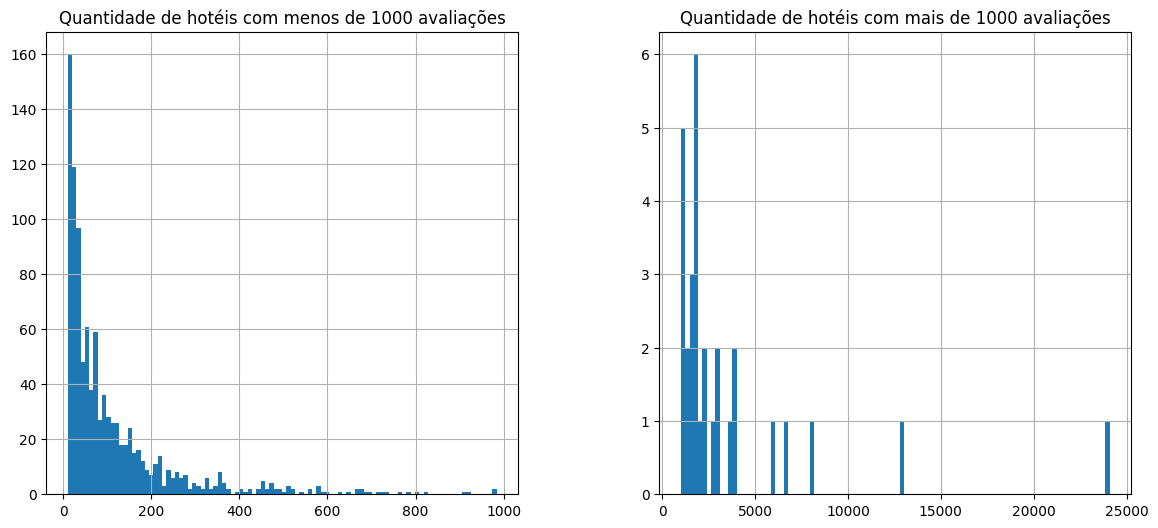

In [12]:
# Make two hist plots side by side
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hotels_small.hist(bins=100, ax=axes[0])
hotels_big.hist(bins=100, ax=axes[1])
axes[0].set_title("Quantidade de hotéis com menos de 1000 avaliações")
axes[1].set_title("Quantidade de hotéis com mais de 1000 avaliações")

In [13]:

for hotel_name in hotels_small.nome.to_list()[-1:]:
    prompt, context = make_prompt_summary_full(hotel_name, df)


make_docs...
len(docs)=10

Você é um assistente de sumarização de hotéis em português.
Utilize os seguintes trechos de CONTEXTO recuperado de avaliações de hotéis para escrever o RESUMO.
Siga as INSTRUÇÕES do usuário para escrever um resumo detalhado do que se pede.

CONTEXTO:
Hotel: Chalés Pouso da Ilha, 0 Estrelas.
Região:NORDESTE; Estado:PERNAMBUCO; Cidade:Ilha de Itamaracá
Tipo:Hotel; Classificação:4.3; Quantidade Avaliações:145

 - Avaliação 1
Nota:5; Curtidas:0; Usuário é guia local
Avaliação: Sensacional ! Para quem aprecia uma praia bacana em um lugar super calmo e acolhedor ! Os chalés pouso da ilha é verdadeiramente tudo isso ! Ficamos hospedados esse final de semana por 3 dias e foi uma sensação sem  igual, conhecemos os proprietários Enrique e Rejane, pessoas da melhor qualidade ! Super recomendo a todos !

 - Avaliação 2
Nota:5; Curtidas:0; Usuário é guia local
Avaliação: Todas pessoas que são convidados pó min , ficam inprecionado com o local

 - Avaliação 3
Nota:5; Curti

In [14]:
llm, _, _ = load_model("gemini-2.0-flash")

load_model...
model_alias='gemini-2.0-flash' max_new_tokens=3000 model_data=('google', 'gemini-2.0-flash')
Loading ChatGoogleGenerativeAI model...
llm=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), temperature=0.0, max_output_tokens=3000, max_retries=2, timeout=10.0, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000023522659790>, default_metadata=())
hf_pipe=<llms.models.GenericHuggingFacePipeline object at 0x0000023524CDC5D0>


In [15]:
from llms.models import query_model

response = query_model(llm, prompt)

query_model...
len(prompt)=3438
num_input_tokens=527
len(response)=1926
response='**Chalés Pouso da Ilha: Resumo Detalhado das Avaliações**\n\n**1. Infraestrutura e Acomodações:**\n\nOs chalés são descritos como super aconchegantes, proporcionando um ambiente tranquilo e organizado, ideal para relaxar a dois ou em família. A proximidade com o mar é um ponto forte. No entanto, uma avaliação aponta para a falta de um número de telefone funcional, indicando uma possível falta de organização e comunicação por parte do empreendimento.\n\n**2. Atendimento e Serviço:**\n\nOs proprietários, Enrique e Rejane, são elogiados pela cordialidade e atenção. Os responsáveis pelo local são considerados super atenciosos, proporcionando um atendimento de qualidade. Contudo, a dificuldade de comunicação, mencionada anteriormente, pode ser um ponto negativo no serviço prestado.\n\n**3. Localização e Acessibilidade:**\n\nA pousada está localizada em frente ao mar, em uma praia sossegada, ideal para quem bus

In [16]:
print(response)

**Chalés Pouso da Ilha: Resumo Detalhado das Avaliações**

**1. Infraestrutura e Acomodações:**

Os chalés são descritos como super aconchegantes, proporcionando um ambiente tranquilo e organizado, ideal para relaxar a dois ou em família. A proximidade com o mar é um ponto forte. No entanto, uma avaliação aponta para a falta de um número de telefone funcional, indicando uma possível falta de organização e comunicação por parte do empreendimento.

**2. Atendimento e Serviço:**

Os proprietários, Enrique e Rejane, são elogiados pela cordialidade e atenção. Os responsáveis pelo local são considerados super atenciosos, proporcionando um atendimento de qualidade. Contudo, a dificuldade de comunicação, mencionada anteriormente, pode ser um ponto negativo no serviço prestado.

**3. Localização e Acessibilidade:**

A pousada está localizada em frente ao mar, em uma praia sossegada, ideal para quem busca descanso. A Praia do Sossego é descrita como maravilhosa, mas há uma preocupação com a suje

In [17]:
from llms.g_eval import g_eval_scores

In [18]:
import pandas as pd
pd.Series([1,1,1,None]).mean()

1.0

In [19]:
result, score_final = g_eval_scores([response], context, llm, 1)

g_eval_scores...
Evaluating summary 0
metric_name='Relevância'
response='- Relevância: 5'
Sleeping 1 seconds...
metric_name='Coerência'
response='4'
Sleeping 1 seconds...
metric_name='Consistência'
response='5'
Sleeping 1 seconds...
metric_name='Fluência'
response='3'
Sleeping 1 seconds...
score_final=4.25 scores=[5, 4, 5, 3]


# Open Router

In [20]:
from llms.models import load_model

In [21]:
llm, model_name, max_new_tokens = load_model("gemini-2.0-flash")

load_model...
model_alias='gemini-2.0-flash' max_new_tokens=3000 model_data=('google', 'gemini-2.0-flash')
Loading ChatGoogleGenerativeAI model...
llm=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), temperature=0.0, max_output_tokens=3000, max_retries=2, timeout=10.0, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000023524CD9C50>, default_metadata=())
hf_pipe=<llms.models.GenericHuggingFacePipeline object at 0x0000023524CC1490>


In [22]:
# Test all models
# for a in models_text:
#     if models_text[a][0] in ["local","google"]:
#         continue
#     print(a)
#     llm, model_name, max_new_tokens = load_model(a)
#     llmresult = llm.generate(["hi"])
#     print(llmresult)
#     response = llmresult.generations[0][0].text
#     print(response)